## 程序说明

#### 目录下保存了训练过程中的损失变化与准确性变化(存为npy文件)，训练后的模型也被保存。若运行该文档时，检测到目录下有这些文件，就会调用display函数展示之前的训练过程，并加载模型测试在测试集上的精确度。删去这些文件可以重新训练模型。

#### 如果没有删除文件，直接点击运行相当于展示之前的训练过程，并加载模型测试在测试集上的精确度，但训练过程中的部分prrint和图像就没了，建议在运行前先阅读程序并看之前展示的图像和数据，阅读完毕后再点击运行，检查模型的效果。

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import os

In [2]:
class NPnetwork():
    def __init__(self,dim_of_input,num_of_neure_in_hidden_layer,dim_of_output, learning_rate = 1e-3):
        self.dim_of_input = dim_of_input
        self.num_of_neure = num_of_neure_in_hidden_layer
        self.dim_of_output = dim_of_output
        self.learning_rate = learning_rate
        
        self.weights_input_hidden = np.random.rand(dim_of_input,num_of_neure_in_hidden_layer) # [d,h]
        self.bias_input_hidden = np.random.rand(num_of_neure_in_hidden_layer)[:,None]
        self.weights_hidden_output = np.random.rand(num_of_neure_in_hidden_layer,dim_of_output) # [h,c]
        self.bias_hidden_output = np.random.rand(dim_of_output)[:,None]
        
    def save_model(self):
        np.savez('model.npz',
                 weights_input_hidden = self.weights_input_hidden,
                 bias_input_hidden = self.bias_input_hidden,
                 weights_hidden_output = self.weights_hidden_output,
                 bias_hidden_output = self.bias_hidden_output)
    
    def load_model(self):
        pretrained_model=np.load('model.npz')
        self.weights_input_hidden = pretrained_model['weights_input_hidden'] # [d,h]
        self.bias_input_hidden = pretrained_model['bias_input_hidden']
        self.weights_hidden_output = pretrained_model['weights_hidden_output']# [h,c]
        self.bias_hidden_output = pretrained_model['bias_hidden_output']
        
    def sigmoid_activation(self, input_x):
        return 1/(1+np.exp(-input_x))
    
    def MSE_loss(self,predict,ground_truth):
        return np.mean(0.5*(predict-ground_truth)**2)
    
    def forward(self,input_features,ground_truth):
        self.input_features = input_features[:,None] # [d,1]
        # print(self.input_features.shape)
        self.hidden_out = ((self.weights_input_hidden).T @ self.input_features + self.bias_input_hidden )# [h,d] @ [d,1] = [h,1]
        # print(self.weights_input_hidden.shape,input_features.shape,self.bias_input_hidden.shape,self.hidden_out.shape)
        self.activation_out = self.sigmoid_activation(self.hidden_out) # [h,1]
        # print(self.activation_out.shape)
        self.output = (self.weights_hidden_output).T @ self.activation_out + self.bias_hidden_output # [c,h] @ [h,1] = [c,1]
        # print(self.output.shape)
        self.loss = self.MSE_loss(self.output,ground_truth)
        return self.output
    
    
    def backward_and_update(self,predict,ground_truth):
        # backward of weights_hidden_output and bias_hidden_output
        d_weights_hidden_output = ((predict-ground_truth) @ self.activation_out.T ).T# [c,1] @ [1,h] =[c,h]  => [h,c]
        d_bias_hidden_output = (predict-ground_truth) # [c,1]
        
        # update the weights_hidden_output and bias_hidden_output
        self.weights_hidden_output = self.weights_hidden_output - self.learning_rate*d_weights_hidden_output
        self.bias_hidden_output = self.bias_hidden_output - self.learning_rate*d_bias_hidden_output
        #--------------------------------------------
        # print(predict.shape,ground_truth.shape)
        
        # # backward of weights_input_hidden and bias_input_hidden
        d_weights_input_hidden = (self.weights_hidden_output @ (predict-ground_truth)) 
        d_weights_input_hidden = d_weights_input_hidden @ self.activation_out.T  
        d_weights_input_hidden = d_weights_input_hidden @(1-self.activation_out)
        d_weights_input_hidden = d_weights_input_hidden @ self.input_features.T
        # [h,c] @ [c,1] =[h,1], [h,1] @ [1,h] = [h,h], [h,h] @ [h,1] = [h,1], [h,1] @ [1,d] = [h,d]
        
        d_weights_input_hidden = d_weights_input_hidden.T
        d_bias_input_hidden = (self.weights_hidden_output @ (predict-ground_truth)) @ self.activation_out.T  @(1-self.activation_out) 
        
        # update weights_input_hidden and bias_input_hidden
        self.weights_input_hidden = self.weights_input_hidden - self.learning_rate*d_weights_input_hidden   
        self.bias_input_hidden = self.bias_input_hidden - self.learning_rate*d_bias_input_hidden
    
    def train(self,input_x,ground_truth):
        # training process includes forward and backward_and_update
        predict = self.forward(input_x,ground_truth)
        self.backward_and_update(predict,ground_truth)
        


In [3]:
def set_seed(seed=0):
    np.random.seed(seed)
    random.seed(seed)
    np.random.seed(seed)

In [4]:
set_seed(10)

# data reading and data pre-processing
Iris_dataset = pd.read_table('iris.data', delimiter=',',header=None) # read data as dataframe
Iris_dataset = Iris_dataset.sample(frac = 1).reset_index(drop=True) # shuffle 

# convert ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica'] into [0 1 2]
category_dic = {}
for i,category in enumerate(Iris_dataset[4].unique()):
    Iris_dataset.loc[Iris_dataset[4]==category,4]=i
    category_dic[i] = category
    
# normalization: min-max
'''
for index, data in Iris_dataset.iteritems():
    max_data = max(data)
    min_data = min(data)
    Iris_dataset.loc[:, index] = (data-min_data)/(max_data-min_data)
    if index is 3:
        break
'''

print(Iris_dataset)
train_dataset = Iris_dataset.loc[:int(0.8*Iris_dataset.shape[0])].values
val_dataset = Iris_dataset.loc[int(0.8*Iris_dataset.shape[0]):].values

       0    1    2    3  4
0    6.3  2.3  4.4  1.3  0
1    6.4  2.7  5.3  1.9  1
2    5.4  3.7  1.5  0.2  2
3    6.1  3.0  4.6  1.4  0
4    5.0  3.3  1.4  0.2  2
5    5.0  2.0  3.5  1.0  0
6    6.3  2.5  4.9  1.5  0
7    5.8  2.7  4.1  1.0  0
8    5.1  3.4  1.5  0.2  2
9    5.7  2.8  4.5  1.3  0
10   5.6  3.0  4.5  1.5  0
11   5.8  2.7  5.1  1.9  1
12   5.5  2.3  4.0  1.3  0
13   4.9  3.0  1.4  0.2  2
14   5.1  3.8  1.5  0.3  2
15   6.8  3.0  5.5  2.1  1
16   6.0  3.4  4.5  1.6  0
17   4.4  3.0  1.3  0.2  2
18   5.1  3.7  1.5  0.4  2
19   5.0  3.2  1.2  0.2  2
20   7.1  3.0  5.9  2.1  1
21   6.4  2.8  5.6  2.2  1
22   6.2  2.8  4.8  1.8  1
23   4.8  3.4  1.9  0.2  2
24   5.9  3.0  4.2  1.5  0
25   4.7  3.2  1.3  0.2  2
26   5.7  3.0  4.2  1.2  0
27   5.5  2.6  4.4  1.2  0
28   6.8  2.8  4.8  1.4  0
29   7.7  3.8  6.7  2.2  1
..   ...  ...  ...  ... ..
120  6.7  3.1  4.7  1.5  0
121  5.8  2.6  4.0  1.2  0
122  6.2  3.4  5.4  2.3  1
123  5.0  3.0  1.6  0.2  2
124  6.0  3.0  4.8  1.8  1
1

/home/zhang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: read_table is deprecated, use read_csv instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [5]:
# define the train function
def train(model, train_set): 
    loss = 0
    accurate_classification = 0
    for _, data in train_set.iterrows(): # read the data row by row
        val_data = (data.values[:-1])
        target = np.array([[0],[0],[0]])
        # print(target.shape)
        target[int(data.values[-1]),:] = 1 # if it is class 2: [0,0,1]
        
        model.train(val_data,target) # a tensor which represents the probability of each category 
        classification = model.output

        loss += model.loss 
        # print(classification, target,data.values[-1])
        classification = classification.tolist()
        if  int( classification.index(max(classification)) ) == int(data.values[-1]):
            # record the correct classification
            accurate_classification += 1
               
    return loss.item()/train_set.shape[0], accurate_classification/train_set.shape[0]

def validation(model, val_set):
    loss = 0
    accurate_classification = 0
    for _, data in val_set.iterrows(): # read the data row by row
        val_data = (data.values[:-1])
        target = np.array([[0],[0],[0]])
        target[int(data.values[-1]),:] = 1 # if it is class 2: [0,0,1]
        
        model.forward(val_data,target) # a tensor which represents the probability of each category 
        classification = model.output
        loss += model.loss 
        
        classification = classification.tolist()
        if  int( classification.index(max(classification)) ) == int(data.values[-1]):
            # record the correct classification
            accurate_classification += 1
               
    return loss.item()/val_set.shape[0], accurate_classification/val_set.shape[0]

In [6]:
# the main function 
def Train_and_Test():
    model = NPnetwork(4,40,3)
    
    # divide the training set and validation set
    train_dataset = Iris_dataset.loc[:int(0.8*Iris_dataset.shape[0])]
    val_dataset = Iris_dataset.loc[int(0.8*Iris_dataset.shape[0]):]

    train_loss_epoch = []
    test_loss_epoch = []
    train_accuracy_epoch = []
    test_accuracy_epoch = []
    for epoch in range(0,200):
        train_loss, train_accuracy = train(model,train_dataset)
        test_loss, test_accuracy = validation(model, val_dataset)
        # print(test_loss)

        train_loss_epoch.append(train_loss)
        test_loss_epoch.append(test_loss)
        train_accuracy_epoch.append(train_accuracy)
        test_accuracy_epoch.append(test_accuracy)
                
    np.save('train_loss_epoch.npy', np.array(train_loss_epoch))
    np.save('test_loss_epoch.npy', np.array(test_loss_epoch))
    np.save('train_accuracy_epoch.npy', np.array(train_accuracy_epoch))
    np.save('test_accuracy_epoch.npy', np.array(test_accuracy_epoch))
    model.save_model()

    return train_loss_epoch,test_loss_epoch,train_accuracy_epoch,test_accuracy_epoch


In [7]:
def visualization(train_loss_epoch,test_loss_epoch,train_accuracy_epoch,test_accuracy_epoch):
    print('Accuracy on train set',train_accuracy_epoch[-1])
    print('Accuracy on validation set',test_accuracy_epoch[-1])

    
    l1,=plt.plot(list(range(len(test_accuracy_epoch))),test_accuracy_epoch)
    l2,=plt.plot(list(range(len(train_accuracy_epoch))),train_accuracy_epoch)
    plt.legend(handles = [l1, l2,], labels = ['validation', 'train'], loc = 'best')
    plt.ylabel('Accuracy') 
    plt.xlabel('epoch')
    plt.title('Accuracy on Train Set and Validation Set') 
    plt.show()
    
    l1,=plt.plot(list(range(len(test_loss_epoch))),test_loss_epoch)
    l2,=plt.plot(list(range(len(train_loss_epoch))),train_loss_epoch)
    plt.legend(handles = [l1, l2,], labels = ['validation', 'train'], loc = 'best')
    plt.ylabel('Loss') 
    plt.xlabel('epoch')
    plt.title('Loss on Train Set and Validation Set') 

    plt.show()

In [8]:
def display():
    test_accuracy_epoch = np.load('test_accuracy_epoch.npy').tolist()
    test_loss_epoch = np.load('test_loss_epoch.npy').tolist()
    train_accuracy_epoch = np.load('train_accuracy_epoch.npy').tolist()
    train_loss_epoch = np.load('train_loss_epoch.npy').tolist()
    
    l1,=plt.plot(list(range(len(test_accuracy_epoch))),test_accuracy_epoch)
    l2,=plt.plot(list(range(len(train_accuracy_epoch))),train_accuracy_epoch)
    plt.legend(handles = [l1, l2,], labels = ['validation', 'train'], loc = 'best')
    plt.ylabel('Accuracy') 
    plt.xlabel('epoch')
    plt.title('Accuracy on Train Set and Validation Set') 
    plt.show()
    
    l1,=plt.plot(list(range(len(test_loss_epoch))),test_loss_epoch)
    l2,=plt.plot(list(range(len(train_loss_epoch))),train_loss_epoch)
    plt.legend(handles = [l1, l2,], labels = ['validation', 'train'], loc = 'best')
    plt.ylabel('Loss') 
    plt.xlabel('epoch')
    plt.title('Loss on Train Set and Validation Set') 
    plt.show()
    
    model = NPnetwork(4,40,3)
    model.load_model()
    _, test_accuracy = validation(model, Iris_dataset.loc[int(0.8*Iris_dataset.shape[0]):])
    print('test_accuracy',test_accuracy)
    

Accuracy on train set 0.9421487603305785
Accuracy on validation set 0.9666666666666667


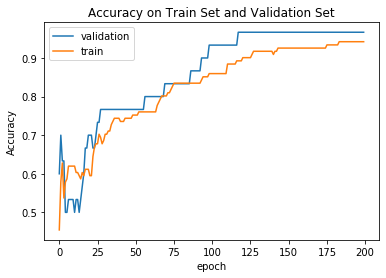

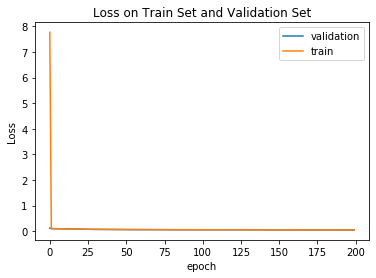

In [9]:
if not os.path.exists('model.npz'):
    train_loss_epoch,test_loss_epoch,train_accuracy_epoch,test_accuracy_epoch = Train_and_Test()
    visualization(train_loss_epoch,test_loss_epoch,train_accuracy_epoch,test_accuracy_epoch)

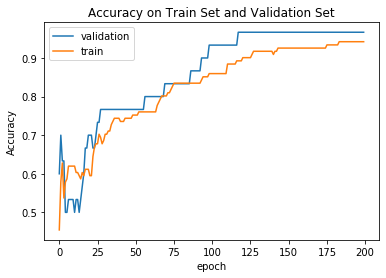

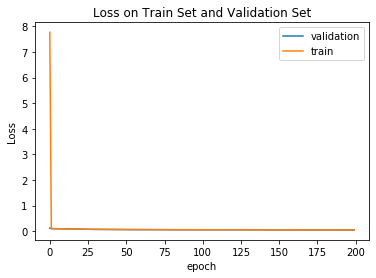

test_accuracy 0.9666666666666667


In [10]:
if os.path.exists('model.npz'):
    display()